In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import data_cleaning as dc
import data_preprocessing as dp
import feature_engineering as fe
from keras.models import Sequential
from keras.layers import Dense
import keras_tuner as kt
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
import time  


Columns with missing values and their counts before preprocessing:
Alley           2593
MasVnrType      1629
MasVnrArea        21
BsmtQual          64
BsmtCond          64
BsmtExposure      67
BsmtFinType1      64
BsmtFinType2      65
Electrical         1
FireplaceQu     1277
PoolQC          2756
Fence           2227
MiscFeature     2671
dtype: int64

Columns with missing values after imputation and their counts:
Series([], dtype: int64)

The dataset contains 2769 rows and 80 columns before outlier removal.
Number of rows removed based on 'GrLivArea' > 4000: 5

The dataset contains 2764 rows and 80 columns after outlier removal.
Categorical variables encoded.
Numerical features standardized.
'SalePrice' standardized.
Explained variance ratio: 0.9513195107448541
PCA Training Time: 0.55 seconds
Training Time for RFE: 107.07 seconds
Epoch 1/100


c:\Users\odpol\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5560 - val_loss: 0.1740
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1406 - val_loss: 0.1181
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1074 - val_loss: 0.1008
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0706 - val_loss: 0.0930
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0679 - val_loss: 0.0924
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0566 - val_loss: 0.0904
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0561 - val_loss: 0.0872
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0488 - val_loss: 0.0875
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0409 - val_loss: 0.0861
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0384 - val_loss: 0.0876
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0377 - val_loss: 0.0877
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0368 - val_lo

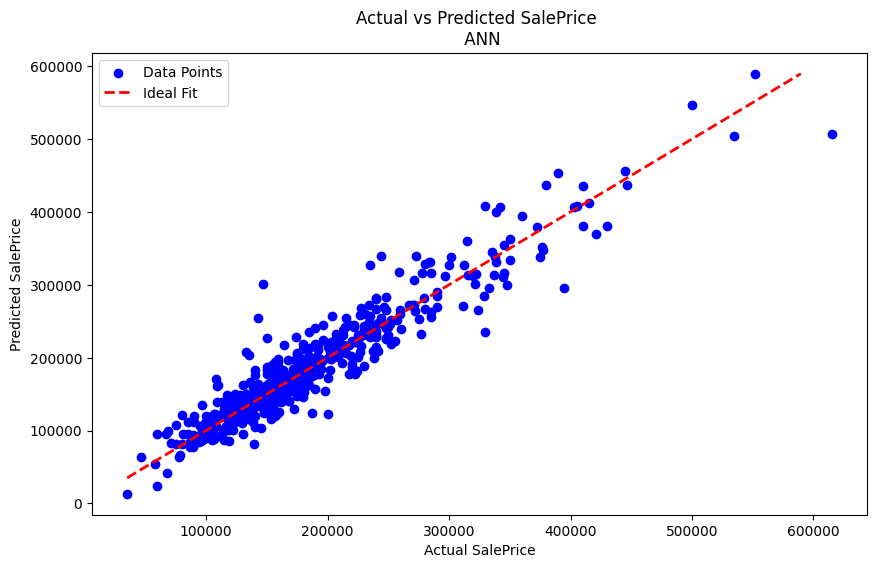

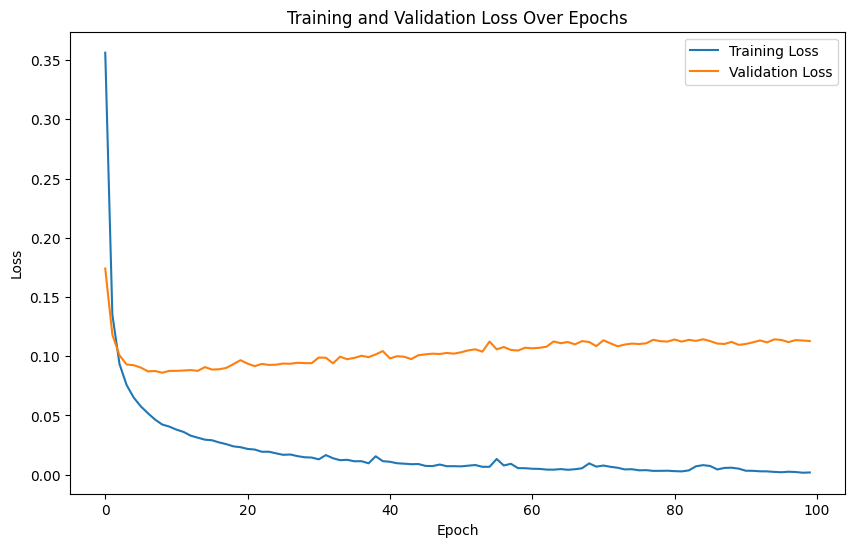

In [2]:
# Load and clean the data
file_path = 'data/AmesData.csv'
ames_df_cleaned = dc.load_and_clean_data(file_path)

# Preprocess the cleaned data
ames_df_preprocessed, saleprice_scaler = dp.preprocess_data(ames_df_cleaned)

# Prepare features and target variable
X = ames_df_preprocessed.drop(['SalePrice'], axis=1)
y = ames_df_preprocessed['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA
X_train_pca, pca = fe.apply_pca(X_train, explained_variance=0.95)
X_test_pca = pca.transform(X_test)

# Apply RFE
X_train_rfe, rfe = fe.apply_rfe(X_train_pca, y_train, n_features=50)
X_test_rfe = rfe.transform(X_test_pca)

# Define the ANN model
model = Sequential()
model.add(Dense(64, input_dim=X_train_rfe.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the ANN model
start_time = time.time()
history = model.fit(X_train_rfe, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
end_time = time.time()
training_time = end_time - start_time

# Make predictions
y_pred = model.predict(X_test_rfe)

# Un-transform the predictions back to the original scale
y_pred_original = saleprice_scaler.inverse_transform(y_pred).flatten()
y_test_original = saleprice_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

# Evaluate the model
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)

print(f"ANN Performance:")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Mean Squared Error (MSE): ${mse:.2f}")
print(f"Training Time: {training_time:.2f} seconds")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, color='blue', label='Data Points')
plt.plot([y_test_original.min(), y_pred_original.max()], [y_test_original.min(), y_pred_original.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice \n ANN')
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


Trial 10 Complete [00h 00m 10s]
val_loss: 0.07692363113164902

Best val_loss So Far: 0.07349428534507751
Total elapsed time: 00h 01m 25s
Epoch 1/100


c:\Users\odpol\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3724 - val_loss: 0.0938
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0754 - val_loss: 0.0855
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0587 - val_loss: 0.0851
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0444 - val_loss: 0.0810
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0318 - val_loss: 0.0803
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0416 - val_loss: 0.0921
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0325 - val_loss: 0.0790
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0222 - val_loss: 0.0844
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0207 - val_loss: 0.0907
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0258 - val_loss: 0.0847
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0213 - val_loss: 0.0855
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0258 - val_l

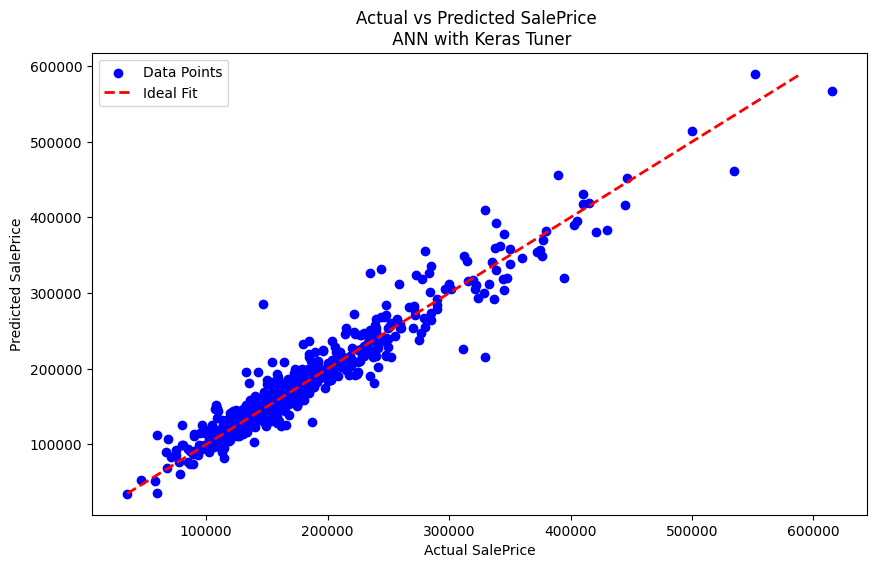

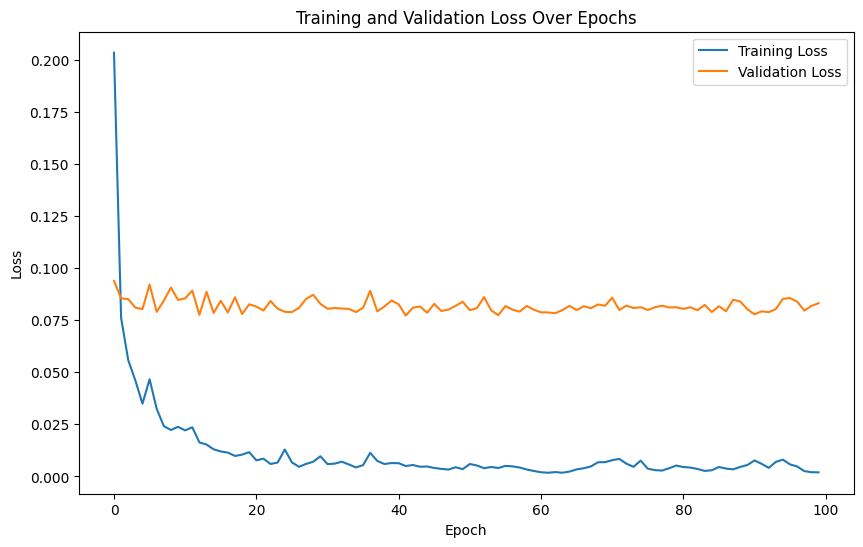

In [5]:
# Load and clean the data
file_path = 'data/AmesData.csv'
ames_df_cleaned = dc.load_and_clean_data(file_path)

# Preprocess the cleaned data
ames_df_preprocessed, saleprice_scaler = dp.preprocess_data(ames_df_cleaned)

# Prepare features and target variable
X = ames_df_preprocessed.drop(['SalePrice'], axis=1)
y = ames_df_preprocessed['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA
X_train_pca, pca = fe.apply_pca(X_train, explained_variance=0.95)
X_test_pca = pca.transform(X_test)

# Apply RFE
X_train_rfe, rfe = fe.apply_rfe(X_train_pca, y_train, n_features=50)
X_test_rfe = rfe.transform(X_test_pca)

# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32), activation='relu', input_dim=X_train_rfe.shape[1]))
    model.add(Dense(units=hp.Int('units_hidden', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize the Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='ames_housing'
)

# Perform hyperparameter tuning
start_time_tuner = time.time()
tuner.search(X_train_rfe, y_train, epochs=50, validation_split=0.2)
end_time_tuner = time.time()

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and train the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_rfe, y_train, epochs=100, validation_split=0.2, verbose=1)
training_time = end_time_tuner - start_time_tuner

# Make predictions
y_pred = model.predict(X_test_rfe)

# Un-transform the predictions back to the original scale
y_pred_original = saleprice_scaler.inverse_transform(y_pred).flatten()
y_test_original = saleprice_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

# Evaluate the model
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)

print(f"ANN Performance:")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Mean Squared Error (MSE): ${mse:.2f}")
print(f"Training Time: {training_time:.2f} seconds")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, color='blue', label='Data Points')
plt.plot([y_test_original.min(), y_pred_original.max()], [y_test_original.min(), y_pred_original.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice \n ANN with Keras Tuner')
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


Using MLPRegressor from sklearn for ANN


Columns with missing values and their counts before preprocessing:
Alley           2593
MasVnrType      1629
MasVnrArea        21
BsmtQual          64
BsmtCond          64
BsmtExposure      67
BsmtFinType1      64
BsmtFinType2      65
Electrical         1
FireplaceQu     1277
PoolQC          2756
Fence           2227
MiscFeature     2671
dtype: int64

Columns with missing values after imputation and their counts:
Series([], dtype: int64)

The dataset contains 2769 rows and 80 columns before outlier removal.
Number of rows removed based on 'GrLivArea' > 4000: 5

The dataset contains 2764 rows and 80 columns after outlier removal.
Categorical variables encoded.
Numerical features standardized.
'SalePrice' standardized.
Explained variance ratio: 0.9513195107448541
PCA Training Time: 36.12 seconds
Training Time for RFE: 146.30 seconds


c:\Users\odpol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Artificial Neural Networks Performance with RFE:
Mean Absolute Error (MAE): $13306.29
Mean Squared Error (MSE): $409229805.35
Training Time: 699.09 seconds
Best Parameters: {'solver': 'sgd', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (200, 200, 200), 'alpha': 1, 'activation': 'relu'}


c:\Users\odpol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


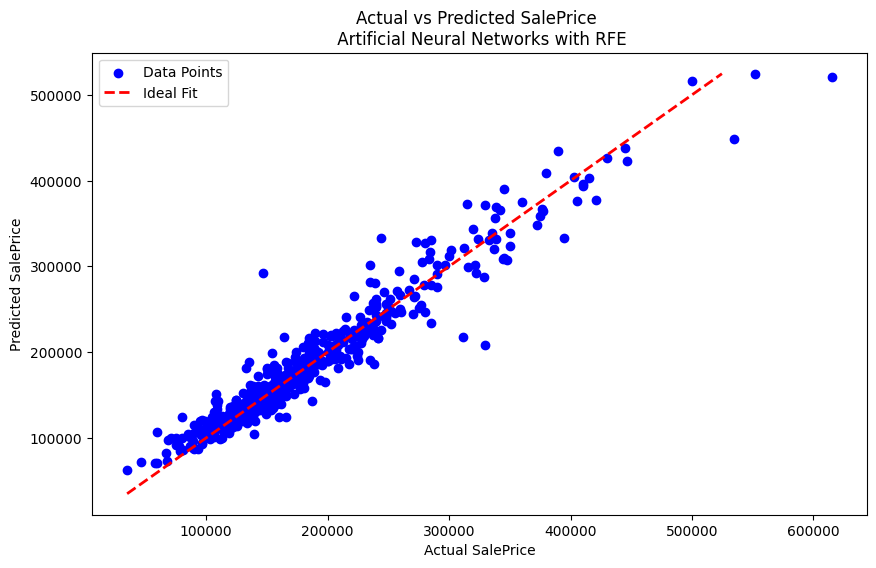

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import data_cleaning as dc
import data_preprocessing as dp
import feature_engineering as fe
from sklearn.neural_network import MLPRegressor
import time 

# Load and clean the data
file_path = 'data/AmesData.csv'
ames_df_cleaned = dc.load_and_clean_data(file_path)

# Preprocess the cleaned data
ames_df_preprocessed, saleprice_scaler = dp.preprocess_data(ames_df_cleaned)

# Prepare features and target variable
X = ames_df_preprocessed.drop(['SalePrice'], axis=1)
y = ames_df_preprocessed['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA
X_train_pca, pca = fe.apply_pca(X_train, explained_variance=0.95)
X_test_pca = pca.transform(X_test)

# Apply RFE
X_train_rfe, rfe = fe.apply_rfe(X_train_pca, y_train, n_features=50)
X_test_rfe = rfe.transform(X_test_pca)

# Define the Artificial Neural Network model
mlp_model = MLPRegressor(max_iter=1000, random_state=42)

# Hyperparameter tuning for ANN
param_grid_ann = {
    'hidden_layer_sizes': [(100, 100, 100), (200, 200, 200)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.05, 0.10, 1],
    'learning_rate': ['constant', 'adaptive'],
}

ann_search = RandomizedSearchCV(mlp_model, param_grid_ann, n_iter=48, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)

start_time_ann = time.time()
ann_search.fit(X_train_rfe, y_train)
end_time_ann = time.time()

# Best parameters from tuning
best_params_ann = ann_search.best_params_

# Train the final ANN model with the best parameters
ann_optimized = MLPRegressor(**best_params_ann, max_iter=1000, random_state=42)
ann_optimized.fit(X_train_rfe, y_train)

# Make predictions
y_pred_ann = ann_optimized.predict(X_test_rfe)

# Un-transform the predictions back to the original scale
y_pred_ann_original = saleprice_scaler.inverse_transform(y_pred_ann.reshape(-1, 1)).flatten()

# Evaluate the model
mae_ann = mean_absolute_error(y_test_original, y_pred_ann_original)
mse_ann = mean_squared_error(y_test_original, y_pred_ann_original)

print("Artificial Neural Networks Performance with RFE:")
print(f"Mean Absolute Error (MAE): ${mae_ann:.2f}")
print(f"Mean Squared Error (MSE): ${mse_ann:.2f}")
print(f"Training Time: {end_time_ann - start_time_ann:.2f} seconds")
print(f"Best Parameters: {best_params_ann}")

# Plot predicted vs. actual for Artificial Neural Networks
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_ann_original, color='blue', label='Data Points')
plt.plot([y_test_original.min(), y_pred_ann_original.max()], [y_test_original.min(), y_pred_ann_original.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice \n Artificial Neural Networks with RFE')
plt.legend()
plt.show()


Columns with missing values and their counts before preprocessing:
Alley           2593
MasVnrType      1629
MasVnrArea        21
BsmtQual          64
BsmtCond          64
BsmtExposure      67
BsmtFinType1      64
BsmtFinType2      65
Electrical         1
FireplaceQu     1277
PoolQC          2756
Fence           2227
MiscFeature     2671
dtype: int64

Columns with missing values after imputation and their counts:
Series([], dtype: int64)

The dataset contains 2769 rows and 80 columns before outlier removal.
Number of rows removed based on 'GrLivArea' > 4000: 5

The dataset contains 2764 rows and 80 columns after outlier removal.
Categorical variables encoded.
Numerical features standardized.
'SalePrice' standardized.
Explained variance ratio: 0.9513195107448541
PCA Training Time: 1.72 seconds
Training Time for RFE: 110.31 seconds


c:\Users\odpol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
50 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\odpol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\odpol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\odpol\AppDa

Artificial Neural Networks Performance with RFE:
Mean Absolute Error (MAE): $12885.29
Mean Squared Error (MSE): $383747356.79
Training Time: 3082.09 seconds
Best Parameters: {'solver': 'sgd', 'learning_rate_init': 0.1, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 100, 100), 'batch_size': 128, 'alpha': 1, 'activation': 'relu'}


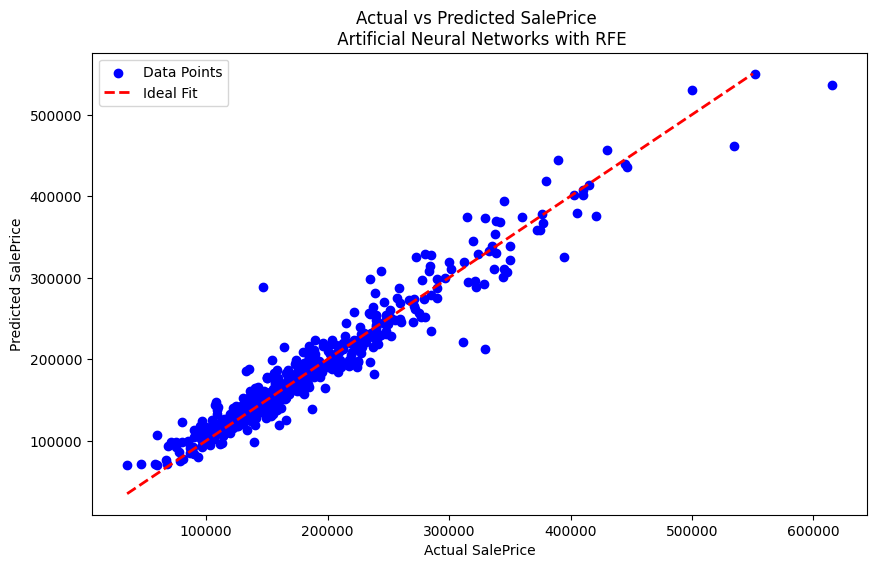

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import data_cleaning as dc
import data_preprocessing as dp
import feature_engineering as fe
from sklearn.neural_network import MLPRegressor
import time

# Load and clean the data
file_path = 'data/AmesData.csv'
ames_df_cleaned = dc.load_and_clean_data(file_path)

# Preprocess the cleaned data
ames_df_preprocessed, saleprice_scaler = dp.preprocess_data(ames_df_cleaned)

# Prepare features and target variable
X = ames_df_preprocessed.drop(['SalePrice'], axis=1)
y = ames_df_preprocessed['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA
X_train_pca, pca = fe.apply_pca(X_train, explained_variance=0.95)
X_test_pca = pca.transform(X_test)

# Apply RFE
X_train_rfe, rfe = fe.apply_rfe(X_train_pca, y_train, n_features=50)
X_test_rfe = rfe.transform(X_test_pca)

# Define the Artificial Neural Network model
mlp_model = MLPRegressor(max_iter=2000, random_state=42)  # Increased max_iter

# Hyperparameter tuning for ANN
param_grid_ann = {
    'hidden_layer_sizes': [(100, 100, 100), (200, 200, 200)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.05, 0.10, 1],
    'learning_rate': ['constant', 'adaptive'],
    'batch_size': [32, 64, 128],  # Added batch_size parameter
    'learning_rate_init': [0.001, 0.01, 0.1],  # Added initial learning rate parameter
}

ann_search = RandomizedSearchCV(mlp_model, param_grid_ann, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)

start_time_ann = time.time()
ann_search.fit(X_train_rfe, y_train)
end_time_ann = time.time()

# Best parameters from tuning
best_params_ann = ann_search.best_params_

# Train the final ANN model with the best parameters
ann_optimized = MLPRegressor(**best_params_ann, max_iter=2000, random_state=42)
ann_optimized.fit(X_train_rfe, y_train)

# Make predictions
y_pred_ann = ann_optimized.predict(X_test_rfe)

# Un-transform the predictions back to the original scale
y_pred_ann_original = saleprice_scaler.inverse_transform(y_pred_ann.reshape(-1, 1)).flatten()

# Evaluate the model
mae_ann = mean_absolute_error(y_test_original, y_pred_ann_original)
mse_ann = mean_squared_error(y_test_original, y_pred_ann_original)

print("Artificial Neural Networks Performance with RFE:")
print(f"Mean Absolute Error (MAE): ${mae_ann:.2f}")
print(f"Mean Squared Error (MSE): ${mse_ann:.2f}")
print(f"Training Time: {end_time_ann - start_time_ann:.2f} seconds")
print(f"Best Parameters: {best_params_ann}")

# Plot predicted vs. actual for Artificial Neural Networks
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_ann_original, color='blue', label='Data Points')
plt.plot([y_test_original.min(), y_pred_ann_original.max()], [y_test_original.min(), y_pred_ann_original.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice \n Artificial Neural Networks with RFE')
plt.legend()
plt.show()
